<a href="https://colab.research.google.com/github/JoshDumo/QuantumChem/blob/main/QN_Sampling_the_PES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling the Potential Energy Surface of HH

This is from the Qiskit Nature Tutorial found here
https://qiskit.org/documentation/nature/tutorials/05_Sampling_potential_energy_surfaces.html

Here we will focus on trying this out in the Colab environment.

## Installing Qiskit, Qiskit Nature and PySCF

In [1]:
!pip install qiskit 
!pip install qiskit_nature
!pip install pyscf

     |████████████████████████████████| 6.0MB 2.7MB/s 
     |████████████████████████████████| 17.9MB 215kB/s 
     |████████████████████████████████| 204kB 52.3MB/s 
     |████████████████████████████████| 215kB 41.0MB/s 
     |████████████████████████████████| 2.1MB 23.3MB/s 
     |████████████████████████████████| 1.0MB 48.4MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 194kB 42.9MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 614kB 40.7MB/s 
     |████████████████████████████████| 3.2MB 36.8MB/s 
     |████████████████████████████████| 5.5MB 48.1MB/s 
  Created wheel for qiskit: filename=qiskit-0.25.2-cp37-none-any.whl size=3066 sha256=5b8d78d7c66395bba679fb1fc693a8d4e8b7b55e9db14bdc45c7557d0f7aa080
  Stored in directory: /root/.cache/pip/wheels/47/a6/95/c06fb36fa3f4de8eb325c737eb8164c1805314f9f5fc941e5b
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py2

## Importing the essentials

In [2]:
# import common packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

# qiskit
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit.algorithms.minimum_eigen_solvers import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import ExcitationPreserving
from qiskit import BasicAer
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SLSQP

# qiskit nature imports
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule
from qiskit_nature.algorithms.pes_samplers import BOPESSampler, Extrapolator

import warnings
warnings.simplefilter('ignore', np.RankWarning)

### Set up the H2 molecule

In [3]:
stretch1 = partial(Molecule.absolute_stretching, atom_pair=(1, 0))
mol = Molecule(geometry=[('H', [0., 0., 0.]),
                        ('H', [0., 0., 0.3])],
                       degrees_of_freedom=[stretch1],
                       )

# pass molecule to PSYCF driver
driver = PySCFDriver(molecule=mol)

In [4]:
print(mol.geometry)

[('H', [0.0, 0.0, 0.0]), ('H', [0.0, 0.0, 0.3])]


### Make a perturbation to the molecule along the absolute_stretching dof

In [5]:
mol.perturbations = [0.2]
print(mol.geometry)

mol.perturbations = [0.6]
print(mol.geometry)

[('H', [0.0, 0.0, 0.0]), ('H', [0.0, 0.0, 0.5])]
[('H', [0.0, 0.0, 0.0]), ('H', [0.0, 0.0, 0.8999999999999999])]


## Now the Born-Oppenheimer Potential Energy Surface Sampler
### To bootstrap or not to bootstrap, that is the question

First use the VQE

In [6]:
es_problem = ElectronicStructureProblem(driver)

qubit_converter = QubitConverter(JordanWignerMapper())
quantum_instance = QuantumInstance(backend=Aer.get_backend('statevector_simulator'))
solver = VQE(quantum_instance=quantum_instance)

me_gsc = GroundStateEigensolver(qubit_converter, solver)

In [7]:
distance1 = partial(Molecule.absolute_distance, atom_pair=(1, 0))
mol = Molecule(geometry=[('H', [0., 0., 0.]),
                        ('H', [0., 0., 0.3])],
                       degrees_of_freedom=[distance1],
                       )

# pass molecule to PSYCF driver
driver = PySCFDriver(molecule=mol)

es_problem = ElectronicStructureProblem(driver)


# Specify degree of freedom (points of interest)
points = np.linspace(0.25, 2, 30)
results_full = {} # full dictionary of results for each condition
results = {} # dictionary of (point,energy) results for each condition
conditions = {False: 'no bootstrapping', True: 'bootstrapping'}


for value, bootstrap in conditions.items():
    # define instance to sampler
    bs = BOPESSampler(
        gss=me_gsc
        ,bootstrap=value
        ,num_bootstrap=None
        ,extrapolator=None)
    # execute
    res = bs.sample(es_problem,points)
    results_full[f'{bootstrap}'] =  res.raw_results
    results[f'points_{bootstrap}'] = res.points
    results[f'energies_{bootstrap}'] = res.energies

Now compare with the Classical solution

In [8]:
# define numpy solver
solver_numpy = NumPyMinimumEigensolver()
me_gsc_numpy = GroundStateEigensolver(qubit_converter, solver_numpy)
bs_classical = BOPESSampler(
               gss=me_gsc_numpy
               ,bootstrap=False
               ,num_bootstrap=None
               ,extrapolator=None)
# execute
res_np = bs_classical.sample(es_problem, points)
results_full['np'] =  res_np.raw_results
results['points_np'] = res_np.points
results['energies_np'] = res_np.energies

## Plot

Text(0, 0.5, 'Energy')

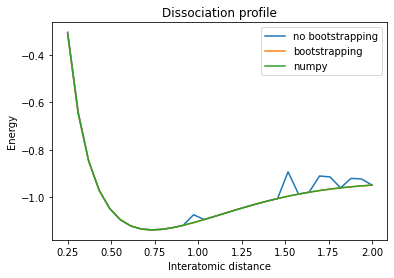

In [9]:
fig = plt.figure()
for value, bootstrap in conditions.items():
    plt.plot(results[f'points_{bootstrap}'], results[f'energies_{bootstrap}'], label = f'{bootstrap}')
plt.plot(results['points_np'], results['energies_np'], label = 'numpy')
plt.legend()
plt.title('Dissociation profile')
plt.xlabel('Interatomic distance')
plt.ylabel('Energy')

## Number of evaluations

In [10]:
for condition, result_full in results_full.items():
    print(condition)
    print('Total evaluations for ' + condition + ':')
    sum = 0
    for key in result_full:
        if condition is not 'np':
            sum += result_full[key].raw_result.cost_function_evals
        else:
            sum = 0
    print(sum)

no bootstrapping
Total evaluations for no bootstrapping:
18613
bootstrapping
Total evaluations for bootstrapping:
2350
np
Total evaluations for np:
0


## Extrapolation

In [11]:
# define different extrapolators
degree = 1
extrap_poly = Extrapolator.factory("poly", degree = degree)
extrap_diff = Extrapolator.factory("diff_model", degree = degree)
extrapolators = {'poly': extrap_poly, 'diff_model': extrap_diff}

for key in extrapolators:
    extrap_internal = extrapolators[key]
    extrap = Extrapolator.factory("window", extrapolator = extrap_internal)
    # define extrapolator
    # BOPES sampler
    bs_extr = BOPESSampler(
        gss=me_gsc
        ,bootstrap=True
        ,num_bootstrap=None
        ,extrapolator=extrap)
    # execute
    res = bs_extr.sample(es_problem, points)

    results_full[f'{key}']= res.raw_results
    results[f'points_{key}'] = res.points
    results[f'energies_{key}'] = res.energies


### Plot

poly
diff_model


Text(0, 0.5, 'Energy')

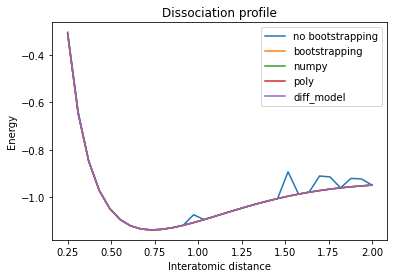

In [12]:
fig = plt.figure()
for value, bootstrap in conditions.items():
    plt.plot(results[f'points_{bootstrap}'], results[f'energies_{bootstrap}'], label = f'{bootstrap}')
plt.plot(results['points_np'], results['energies_np'], label = 'numpy')
for condition in extrapolators.keys():
    print(condition)
    plt.plot(results[f'points_{condition}'], results[f'energies_{condition}'], label = condition)
plt.legend()
plt.title('Dissociation profile')
plt.xlabel('Interatomic distance')
plt.ylabel('Energy')

### Number of evaluations

In [13]:
for condition, result_full in results_full.items():
    print(condition)
    print('Total evaluations for ' + condition + ':')
    sum = 0
    for key in results_full[condition].keys():
        if condition is not 'np':
                sum += result_full[key].raw_result.cost_function_evals
        else:
                sum = 0
    print(sum)

no bootstrapping
Total evaluations for no bootstrapping:
18613
bootstrapping
Total evaluations for bootstrapping:
2350
np
Total evaluations for np:
0
poly
Total evaluations for poly:
1003
diff_model
Total evaluations for diff_model:
1555
